Utilizzo di pynetlogo per una singola simulazione.

È una pessima idea lanciare run all.

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
#import networkx as nx

%matplotlib widget

### Impostazioni

In [ ]:
outputdir = './outputs/update1/sim0/' # directory dove salvare config e output

nl_gui = False           # false per non far partire la gui di netlogo
nl_model = "./EC.nlogo" # modello da caricare in netlogo

Runnare una delle due celle seguenti in base a se vuoi cambiare variabili o caricarle da un file

In [3]:
# CARICAMENTO VARIABILI DA FILE
with open(outputdir+"global_vars.json",'r') as f:
  global_vars = json.load(f)

print(global_vars)

{'N': 1000, 'beta': 0.8, 'mutrue': 0.0, 'vartrue': 1.0, 'update-type': 1, 'var-c': 0.25, 'var-d': 2}


In [6]:
# IMPOSTAZIONE VARIABILI GLOBALI DA PYTHON e salvataggio nel file
global_vars = {
  'N': 1000,
  'beta': 0.8,
  'mutrue': 0.,
  'vartrue': 1.,
  'update-type': 1,
  'var-c': 0.25,
  'var-d': 2
}

with open(outputdir+"global_vars.json",'x') as f:
  f.write(json.dumps(global_vars,indent=2))

### Simulazione singola

#### Caricamento netlogo

In [4]:
## perché funzioni: installato tutto da conda tranne pynetlogo, installato per ultimo
## java-21-openjdk
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

In [ ]:
netlogo.load_model(nl_model)

In [40]:
# IMPOSTAZIONE VARIABILI GLOBALI E SETUP IN NETLOGO
netlogo.command('clear-all')
for name in global_vars:
  netlogo.command(f'set {name} {global_vars[name]}')

netlogo.command('setup')

In [7]:
netlogo.report('vartrue')

1.0

In [8]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [7]:
values('var').max()

np.float64(5.828571341171454)

#### Avvio simulazione

In [41]:
iters = 100
mus = []
sigma2s = []
mus.append(values('mu0'))
sigma2s.append(values('var0'))


In [42]:
for n in range(1,iters+1):
  netlogo.command('go')
  mus.append(values('mu'))
  sigma2s.append(values('var'))
  print(f"\r{n}/{iters}",end="",flush=True)
print()

1/100

100/100


In [11]:
netlogo.report("iter")

100.0

In [43]:
meanmu = np.array([np.mean(mu) for mu in mus])
meansigma = np.sqrt(np.array([np.mean(var) for var in sigma2s]) )

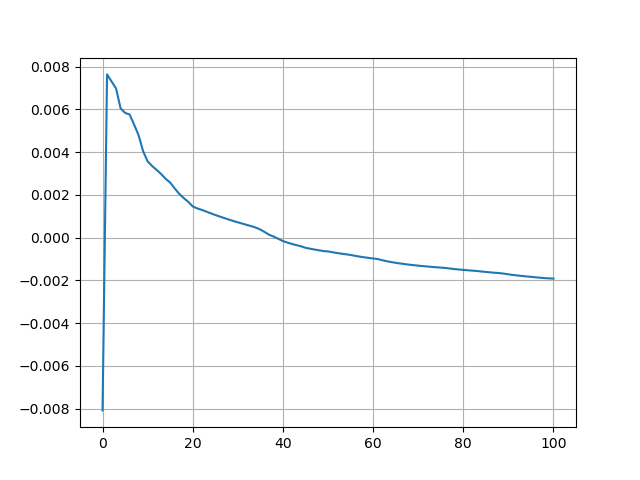

In [44]:
plt.close('all')
plt.plot(meanmu)
plt.grid()

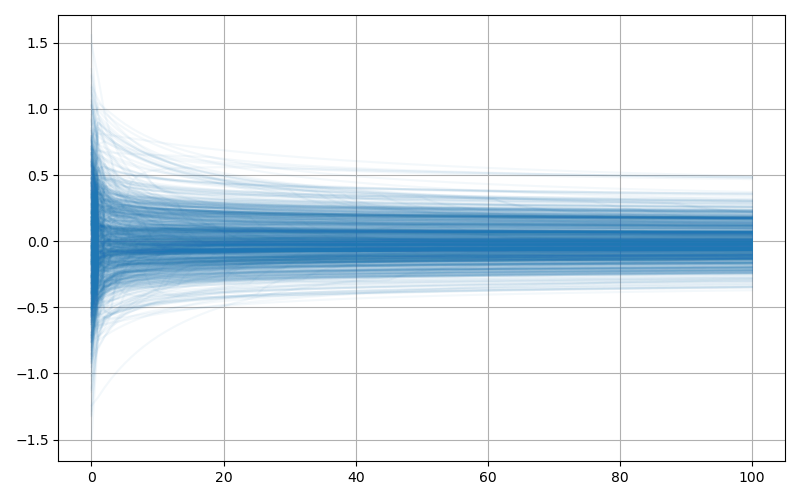

In [45]:
fig, ax = plt.subplots(figsize = (8,5), layout='tight')
for i in range(1000):
  ax.plot([mu[i] for mu in mus],alpha=0.05, color='C0')

#ax.plot( np.array(mus)[:,0] )

ax.grid()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  2.,
         1.,  1.,  0.,  2.,  0.,  2.,  6.,  4.,  5.,  3.,  5., 11., 10.,
         8.,  3., 13., 11., 16., 15., 23., 20., 13., 16., 24., 19., 23.,
        21., 32., 19., 20., 26., 36., 28., 25., 25., 28., 21., 13., 25.,
        15., 36., 26., 24., 27., 19., 19., 14., 23., 21., 19., 21., 16.,
        12., 12.,  8., 16.,  9., 10.,  8., 13.,  6.,  7.,  7.,  4.,  3.,
         1.,  3.,  2.,  1.,  4.,  3.,  0.,  2.,  1.,  3.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-1.51042523, -1.47974892, -1.4490726 , -1.41839629, -1.38771998,
        -1.35704366, -1.32636735, -1.29569104, -1.26501472, -1.23433841,
        -1.2036621 , -1.17298579, -1.14230947, -1.11163316, -1.08095685,
        -1.05028053, -1.01960422, -0.98892791, -0.95825159, -0.92757528,
        -0.89689897, -0.86622266, -0.83554634, -0.80487003, -0.77419372,
        -0.7435174 , -0.71284109, -0.68216478, -0.65148847, -0.620812

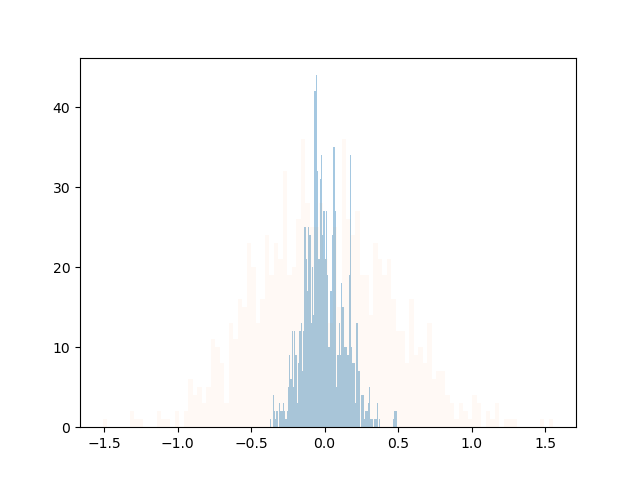

In [46]:
plt.close('all')
plt.hist(mus[-1],bins=100,alpha=0.4)
plt.hist(mus[0],bins=100,alpha=0.04)

In [20]:
np.min(mus[-1])

np.float64(-0.37732368996637217)

In [49]:
netlogo.kill_workspace()

#### Salvataggio medie e varianze
metto una stringa con data e ora prima per identificare le simulazioni; la cartella definita sopra identifica il setup.

`*outputdir*/MESE_GIORNO_ORE_MINUTI_mus.npy`

si riaprono con `np.load(*path*)`

Manca un modo per analizzare la struttura del grafo.

In [47]:
import datetime
datestr = datetime.datetime.now().strftime("%m_%d_%H_%M")
datestr

'05_23_11_51'

In [48]:
np.save(outputdir+datestr+"_mus.npy",mus)
np.save(outputdir+datestr+"_sigma2s.npy",sigma2s)

### Simulazioni multiple

In [80]:
num_sim = 10 #numero di simulazioni da effettuare
iters = 100  #iterazioni per ogni simulazione

muzeros = [] # liste che conterranno tutte le mu di tutte le simulazioni
sigma2zeros = []
mufinals = []
sigma2finals = []

In [78]:
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

netlogo.load_model(nl_model)

In [53]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [81]:
for sim in range(num_sim):
  netlogo.command('clear-all')
  for name in global_vars:
    netlogo.command(f'set {name} {global_vars[name]}')

  netlogo.command('setup')

  muzeros.append(values('mu0'))
  sigma2zeros.append(values('var0'))

  for n in range(1,iters+1):
    netlogo.command('go')
    #mus.append(values('mu'))
    #sigma2s.append(values('var'))
    print(f"\rSimulazione {sim}, timestep {n}/{iters}",end="",flush=True)
  print()
  mufinals.append(values('mu'))
  sigma2finals.append(values('var'))

Simulazione 0, timestep 100/100
Simulazione 1, timestep 100/100
Simulazione 2, timestep 100/100
Simulazione 3, timestep 100/100
Simulazione 4, timestep 100/100
Simulazione 5, timestep 100/100
Simulazione 6, timestep 100/100
Simulazione 7, timestep 100/100
Simulazione 8, timestep 100/100
Simulazione 9, timestep 100/100


In [82]:
netlogo.kill_workspace()

In [83]:
amus = np.array(mufinals)
asigma2s = np.array(sigma2finals)

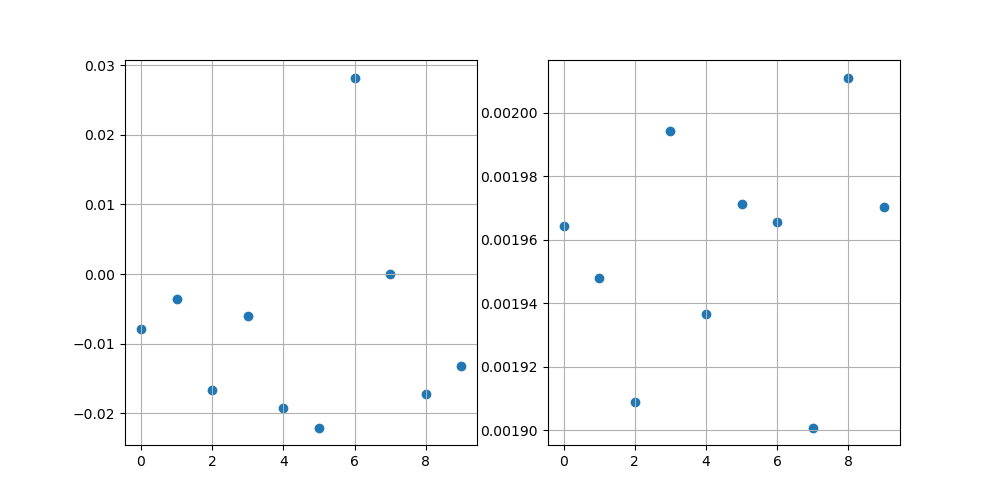

In [87]:
fig, ax = plt.subplots(ncols=2, figsize =(10,5))
ax[0].scatter(np.arange(10),np.mean(amus,axis=1))
ax[1].scatter(np.arange(10),np.mean(asigma2s,axis=1))


for a in ax:
  a.grid()

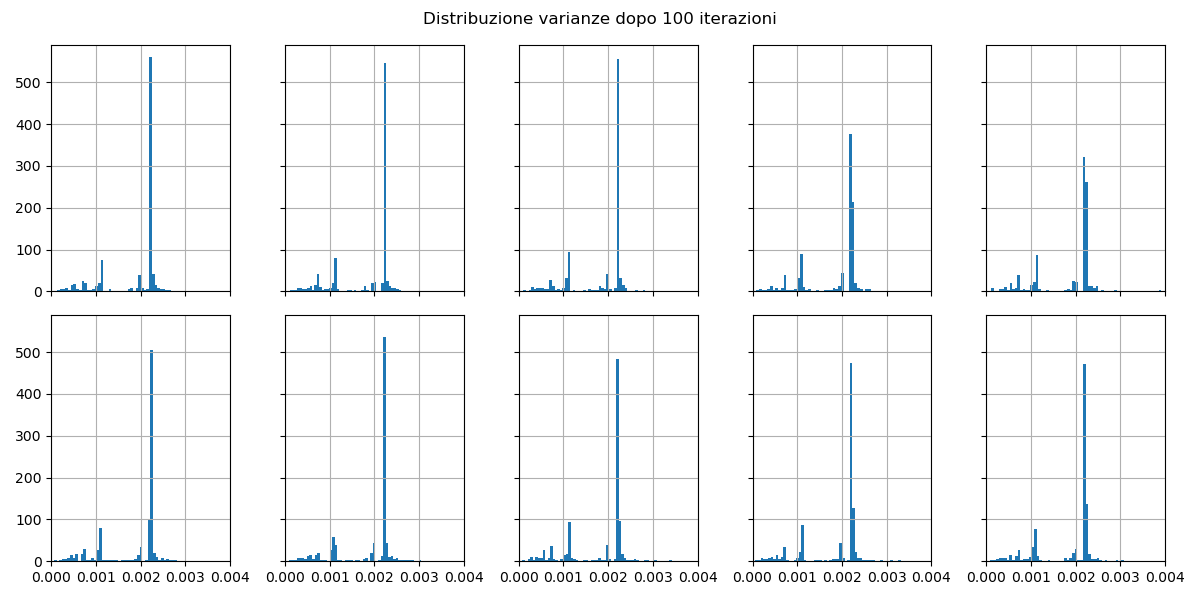

In [115]:
fig1,ax1 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all', sharex='all',layout='tight')
fig1.suptitle('Distribuzione varianze dopo 100 iterazioni')
for i,a in enumerate(ax1.flatten()):
  a.hist(asigma2s[i],bins=300)
  a.set_xlim((0,0.004))
  a.grid()

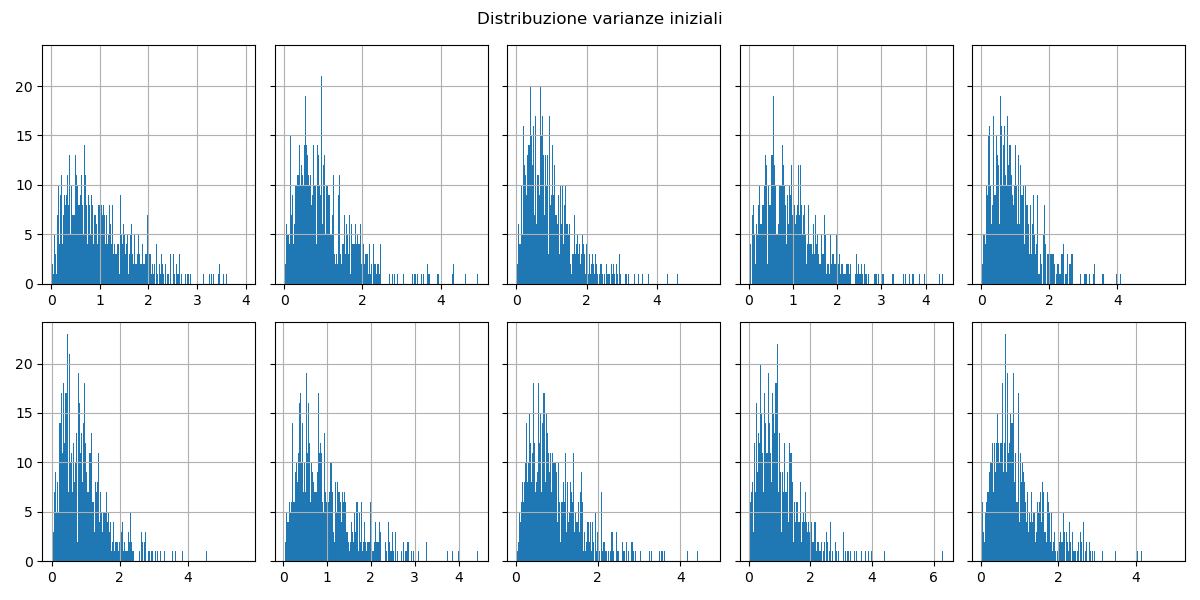

In [116]:
fig2,ax2 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',layout='tight')
fig2.suptitle('Distribuzione varianze iniziali')
for i,a in enumerate(ax2.flatten()):
  a.hist(sigma2zeros[i],bins=300)
  #a.set_xlim((0,0.004))
  a.grid()

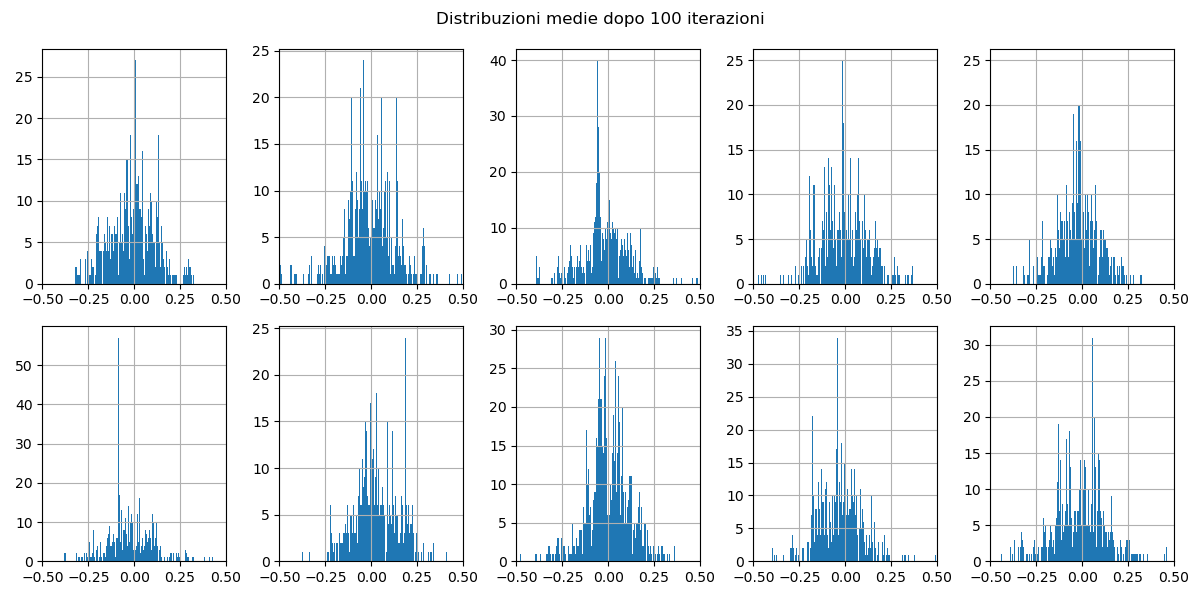

In [118]:
fig3,ax3 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='none',layout='tight')
fig3.suptitle("Distribuzioni medie dopo 100 iterazioni")
for i,a in enumerate(ax3.flatten()):
  a.hist(amus[i],bins=300)
  a.set_xlim((-0.50,0.5))
  a.grid()

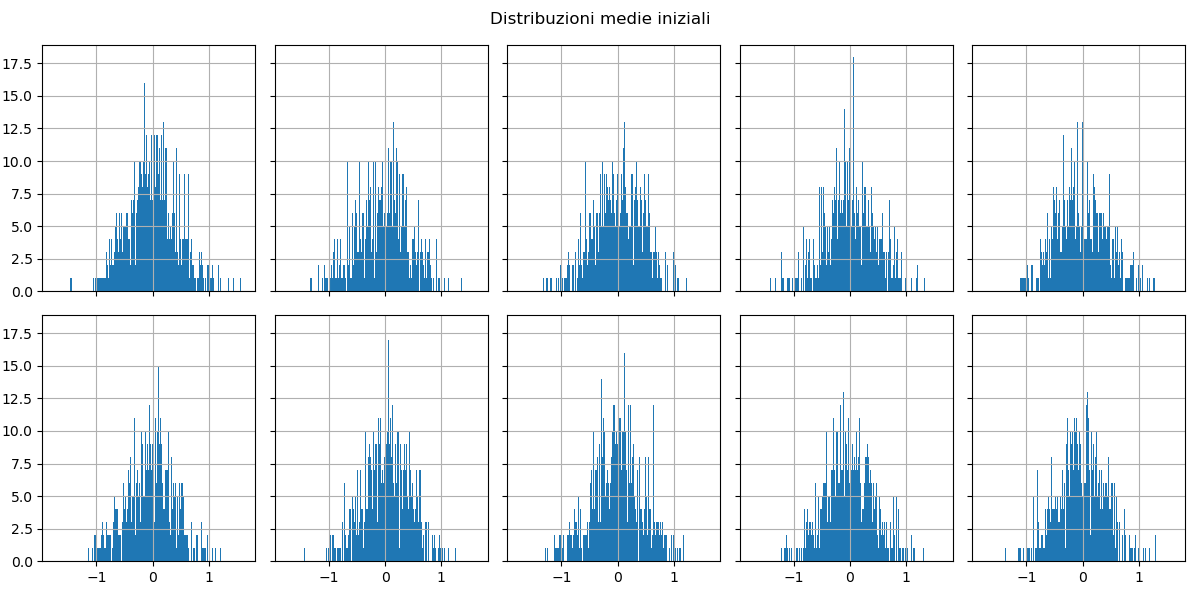

In [119]:
fig4,ax4 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',sharex='all',layout='tight')
fig4.suptitle("Distribuzioni medie iniziali")
for i,a in enumerate(ax4.flatten()):
  a.hist(muzeros[i],bins=300)
  #a.set_xlim((-0.50,0.5))
  a.grid()

In [120]:
fig1.savefig(outputdir+'finalsigmas.png')
fig2.savefig(outputdir+'initialsigmas.png')
fig3.savefig(outputdir+'finalmus.png')
fig4.savefig(outputdir+'initialmus.png')


In [121]:
plt.close('all')

In [137]:
datestr = (datetime.datetime.now()).strftime("%m_%d_%H_%M_")
np.save(outputdir+datestr+"10mus.npy", np.stack([np.array(muzeros),amus]) )
np.save(outputdir+datestr+"10sigma2s.npy", np.stack([np.array(sigma2zeros),asigma2s]))